In [57]:
import os
import numpy as np
import pandas as pd
import pickle
# import sklearn.linear_model as sklm
# import sklearn.model_selection as skms
# import sklearn.feature_selection
import sklearn.pipeline
# from sklearn.utils import shuffle
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# Import our custom functions
from load_data import load_data 
import seaborn as sns

Load training and validation data:

x data is an array of N*784 pixels (N = 2102 for tr, 600 for va)

y is a dataframe of index, class_name and class_id

In [58]:
x_tr, y_tr_df = load_data('x_train.csv', 'y_train.csv')
x_va, y_va_df = load_data('x_valid.csv', 'y_valid.csv')
x_te = load_data('x_test.csv', 'y_valid.csv')[0]


for label, arr in [('train', x_tr), ('valid', x_va)]:
    print("Contents of %s_x.csv: arr of shape %s" % (
        label, str(arr.shape)))

Contents of train_x.csv: arr of shape (2102, 784)
Contents of valid_x.csv: arr of shape (600, 784)


Plot a random image from the validation data for each category

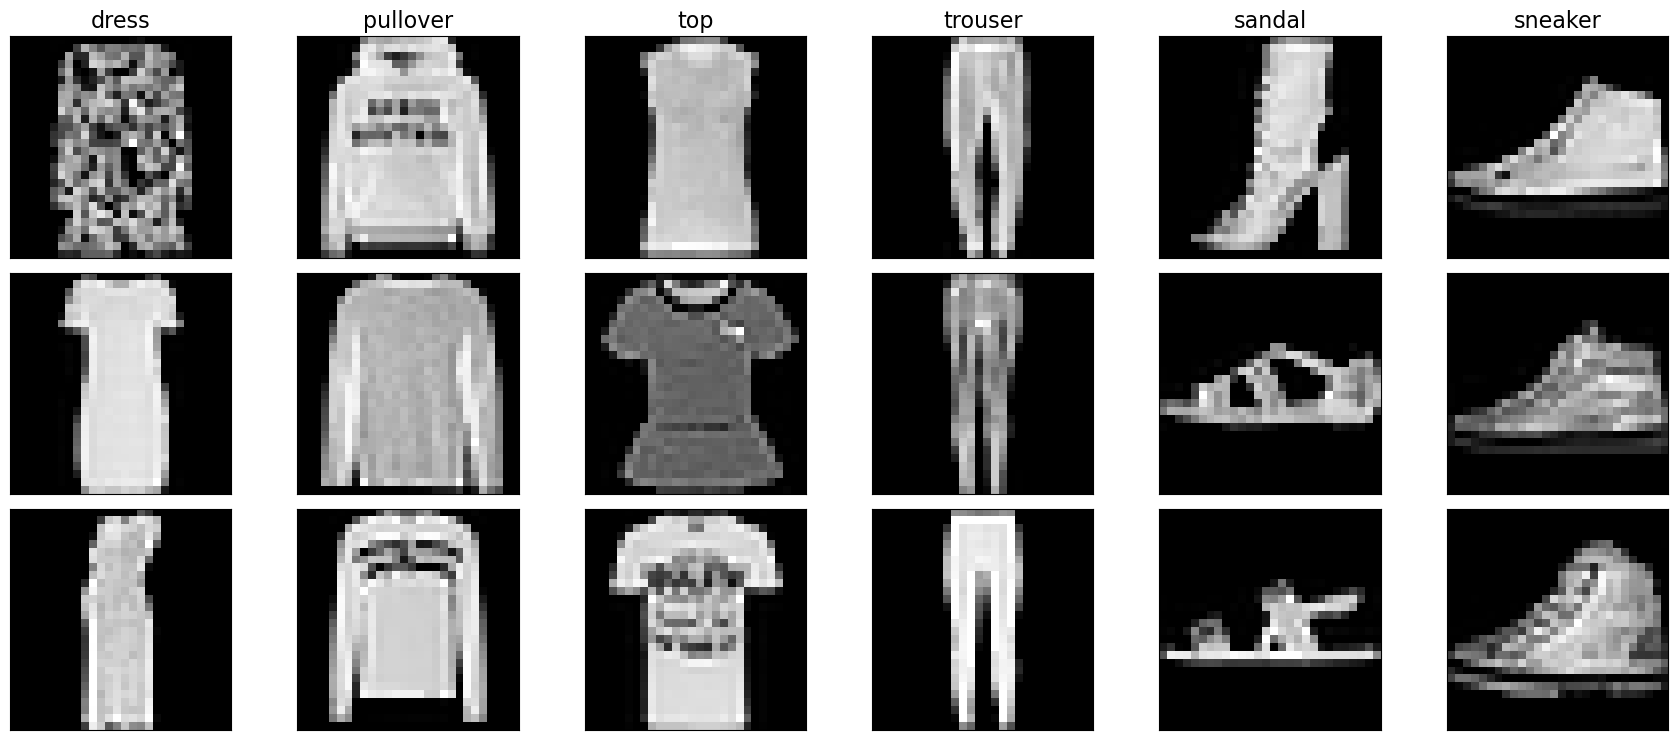

In [59]:
# prng = np.random.RandomState(0)
prng = np.random.RandomState()
N = 3 # num examples of each class to show
fig, axgrid = plt.subplots(N, 6, figsize=(6*3, N*2.5))

for ll, label in enumerate(['dress', 'pullover', 'top', 'trouser', 'sandal', 'sneaker']):
    match_df = y_va_df.query("class_name == '%s'" % label)
    match_ids_N = prng.choice(match_df.index, size=N)        
    for ii, row_id in enumerate(match_ids_N):
        ax = axgrid[ii, ll]
        x_SS = x_va[row_id].reshape((28,28))
        ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
        ax.set_xticks([]); ax.set_yticks([]);
        if ii == 0:
            ax.set_title(label, fontsize=16)
plt.subplots_adjust(left=0.01, right=0.99, wspace=.2, hspace=.01)
plt.tight_layout();
plt.show();

# Data Exploration 1a

In [60]:
tr_class_dist = y_tr_df['class_name'].value_counts()
val_class_dist = y_va_df['class_name'].value_counts()

print('Training class distribution:\n' + str(tr_class_dist))
print('Validation class distribution:\n' + str(val_class_dist))


Training class distribution:
sandal      800
sneaker     800
dress       400
pullover    100
top           1
trouser       1
Name: class_name, dtype: int64
Validation class distribution:
dress       100
trouser     100
sandal      100
top         100
pullover    100
sneaker     100
Name: class_name, dtype: int64


The training data is heavily skewed with data from sandals and trainers, with only one training image for 2 classes. A challenge will be gaining a balanced weighting for each of the classes such that the dominant classes aren't always favoured by the classifier.

# Model

Run search with predefined split s.t. validation set is used for hyperparameter selection

In [61]:
# Combine training and validation datasets
x_all = np.vstack((x_tr,x_va))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr.shape, x_va.shape, x_all.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators)


Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

Splitter dimensions: 2702


# Random search
Load previous model or run new model

In [62]:
# TODO finish
#batch size only for non-lbfgs. 
#Learning Rate = const, adaptive, etc... ONLY for sgd
#early_stopping only for sgd/adam.
rand_param_dist = dict(hidden_layer_sizes=[(10,),(20,),(50,),(100,),(200,),(500,)], activation='identity', alpha = np.logspace(-5,5,50), learning_rate_init=np.logspace(-5, 5, 100), max_iter = [50, 100, 200, 300])

ran_dup_fashion_pipes = sklearn.pipeline.Pipeline([
    ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier (activation='identity', solver='lbfgs', shuffle=True, random_state=0), rand_param_dist, scoring='balanced_accuracy', error_score='raise', return_train_score=True, n_iter=16, cv= my_splitter, n_jobs = -1, refit= False, random_state=0))
])

In [63]:
flag = 'stop'
filename = '1B_rand_search_400.sav'

if os.path.isfile("./" + filename) AND flag != 'run'::
    fashion_pipes = pickle.load(open(filename, 'rb'))
else:
    param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(10,),(20,),(50,),(100,),(200,),(500,)])

    fashion_pipes = sklearn.pipeline.Pipeline([
        ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=400, cv= my_splitter, n_jobs = -1, refit=False))
    ])

    fashion_pipes.fit(x_all, y_all_df['class_name'])

    pickle.dump(fashion_pipes, open(filename, 'wb'))

In [64]:
gridRes = fashion_pipes['rand_search'].cv_results_
bestIdx = fashion_pipes['rand_search'].best_index_ # idx 12, 16, 44 all scored the same

bestIdxs = [12,16,44]
bestParams = dict()
bestParams[0] = {k:v[bestIdxs[0]] for k,v in gridRes.items()}
bestParams[1] = {k:v[bestIdxs[1]] for k,v in gridRes.items()}
bestParams[2] = {k:v[bestIdxs[2]] for k,v in gridRes.items()}

# display(bestParams)

print(gridRes["rank_test_score"])
# display(gridRes["mean_test_score"])

[ 85  51 100 255 349 182  85  85 209 150 209 117 150 209  85 306 128 150
 150 255 209  67 100  85 100 100 382  67 269 128  42 382 317 306  23   1
 150 334  51   1 255 349   1 334 209 150 349  23 100 209 150 349 150 209
 150 100 269 349 192 255 382 209 317 100 100   1 100 317 334 209  85 150
 382 209 209 128 317 349  23 349  85 209 382 209 182 269 269 209 269 128
 209 209 192 334 334  67 349 192 269  51 150 349 269 349 209 334 255 269
 317   1 306 382 317  51 192 192 306   1  67 382 192 117  67 382  42 117
  42 349  85 317 306  23   1  51 317 150   1 209 269   1 269 255  23 269
   1  51 317 209 209 269 349 334  67 209 269 150  23  85 150 117 382 192
 117  23  67 269 349 128  42 269 209 269 117 349 128  67 317   1   1 209
 209 100 382 269  23 100  85  67 334 269 150  67  67 382 209 209 255  42
 317  23 128   1 349 209 182 150 209 128 150 128 117 209 382 306 317  51
 150 269 209 192 269   1 182 349 182 382 255 382 209 150 269 128 150 269
 317 349 128 349 269 269 349  23 182  67 269  51 18

In [65]:
bestMLP1b = sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True, learning_rate_init=1e-05,learning_rate ='constant',hidden_layer_sizes=(500,),activation='identity')
bestMLP1b.fit(x_tr,y_tr_df["class_name"])

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(500,), learning_rate_init=1e-05,
              random_state=0, solver='lbfgs')

In [66]:
tr_acc = sklearn.metrics.balanced_accuracy_score(y_tr_df['class_name'], bestMLP1b.predict(x_tr))
va_acc = sklearn.metrics.balanced_accuracy_score(y_va_df['class_name'], bestMLP1b.predict(x_va))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

Training balanced accuracy: 1.000000
Validation balanced accuracy: 0.733333


In [67]:
pred_tr = bestMLP1b.predict(x_tr)
pred_va = bestMLP1b.predict(x_va)
pred_te = bestMLP1b.predict(x_te)

# Save output of prediction on test data to a file.
np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')

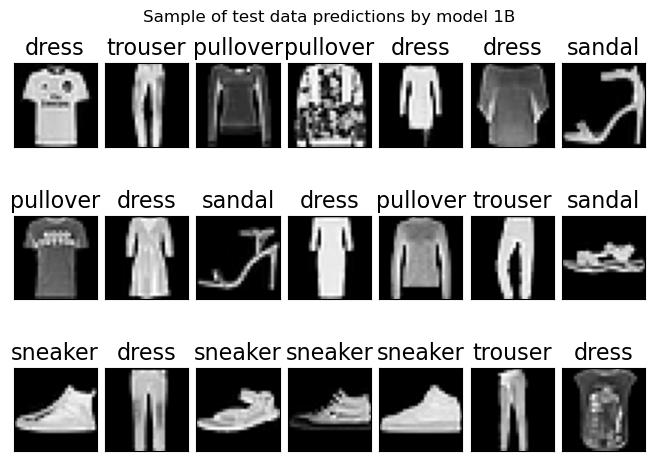

In [68]:
# Plot test data
rows = 3
cols = 7
fig, axgrid = plt.subplots(rows, cols, layout="constrained")

for imageID in range(rows*cols):
    ax = axgrid[np.unravel_index( imageID, (rows,cols))]
    x_SS = x_te[imageID].reshape((28,28))
    ax.imshow(x_SS, vmin=0, vmax=255, cmap='gray')
    ax.set_xticks([]); ax.set_yticks([]);
    label = pred_te[imageID]
    ax.set_title(label, fontsize=16)
# plt.tight_layout();
fig.suptitle("Sample of test data predictions by model 1B")
plt.show();

# Grid Search

In [69]:
# TODO refine search using gridsearchcv
# param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

# fashion_pipes = sklearn.pipeline.Pipeline([
#     ('rand_search', GridSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_splitter, n_jobs = -1, refit=False))
# ])

# fashion_pipes.fit(x_all, y_all_df['class_name'])

In [70]:
# When refit is true we can use the best_estimator_ method, but this doesn't work with refit=false - here we need to manually run a fit on our training set.

# best_est_1 = fashion_pipes['rand_search'].best_estimator_

# pred_tr = best_est_1.predict(x_tr)
# pred_va = best_est_1.predict(x_va)
# pred_te = best_est_1.predict(x_te)

# # Save output of prediction on test data to a file.
# np.savetxt('yhat_test.txt', pred_te, delimiter='\n', fmt='%s')
# sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True)

Ignore for the time being - this was done with refit = true, which fits the final model from randomizedSearchCV onto the entire dataset (tr+val).

![Balanced acc of 1.0 or tr and val](best_estimator_1.png)


# Repeat with data normalized

In [71]:
# normalize data - necessary
x_tr_norm = x_tr /255
x_va_norm = x_va /255


In [72]:
# Combine training and validation datasets
x_all_norm = np.vstack((x_tr_norm,x_va_norm))
y_all_df = pd.concat([y_tr_df,y_va_df])

print("Training X shape: %s\nValidation X shape: %s\nCombined X shape: %s\n" % (x_tr_norm.shape, x_va_norm.shape, x_all_norm.shape))
print("Training Y shape: %s\nValidation Y shape: %s\nCombined Y shape: %s\n" % (y_tr_df.shape, y_va_df.shape, y_all_df.shape))

valid_indicators = np.hstack([
    -1 * np.ones(y_tr_df.shape[0]), # -1 means never include this example in any test split
    0  * np.ones(y_va_df.shape[0]), #  0 means include in the first test split (we count starting at 0 in python)
    ])

# Define custom splitter to use only the validation dataset for hyperparameter selection
print("Splitter dimensions: %i" % (valid_indicators.shape[0]))
my_splitter = sklearn.model_selection.PredefinedSplit(valid_indicators)


Training X shape: (2102, 784)
Validation X shape: (600, 784)
Combined X shape: (2702, 784)

Training Y shape: (2102, 2)
Validation Y shape: (600, 2)
Combined Y shape: (2702, 2)

Splitter dimensions: 2702


In [78]:
flag = 'stop'
filename = '1Bnorm_rand_search_100.sav'

if os.path.isfile("./" + filename) AND flag != 'run'::
    fashion_pipes_norm = pickle.load(open(filename, 'rb'))
else:
    param_dist = dict(activation=['relu', 'logistic', 'identity', 'tanh'], learning_rate_init=np.logspace(-5, 5, 100), learning_rate = ['constant','adaptive'], hidden_layer_sizes=[(20,),(50,),(100,),(200,),(500,)])

    fashion_pipes_norm = sklearn.pipeline.Pipeline([
        ('rand_search', RandomizedSearchCV(sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True), param_dist, scoring='balanced_accuracy', error_score='raise', random_state=0, return_train_score=True, n_iter=100, cv= my_splitter, n_jobs = -1, refit=False))
    ])

    fashion_pipes_norm.fit(x_all_norm, y_all_df['class_name'])
    pickle.dump(fashion_pipes, open(filename, 'wb'))

In [80]:
filename = '1D_initial_RanSearch.sav'
print("./" + filename)

os.path.isfile("./" + filename)

./1D_initial_RanSearch.sav


True

In [74]:
# Assess the same procedure with normalized input data - same results and same accuracy found in this case.display

gridRes = fashion_pipes['rand_search'].cv_results_

display(gridRes)
bestIdxNorm = fashion_pipes['rand_search'].best_index_ # idx 12, 16, 44 all scored the same

bestIdxs = [12,16,44]
bestParams = dict()
bestParams[0] = {k:v[bestIdxs[0]] for k,v in gridRes.items()}
bestParams[1] = {k:v[bestIdxs[1]] for k,v in gridRes.items()}
bestParams[2] = {k:v[bestIdxs[2]] for k,v in gridRes.items()}

display(bestParams)
# print(gridRes["mean_test_score"])
# display(gridRes["mean_test_score"])

{'mean_fit_time': array([140.44210458,   6.839746  ,  12.74384928,  51.5882411 ,
         15.77053523,  59.78591084, 141.80033326, 138.78504324,
         32.13384533,  71.27403617,  32.07315779, 127.27462769,
         13.18552995,  34.87966108, 140.3087337 ,  27.32396173,
         10.98254538,  77.96713805,  75.97740626,  53.15213823,
         91.95694637,  29.70326161,  16.17916346, 138.83797431,
         11.80799818,  12.85146093,   7.76301813,  29.58679366,
         11.91404581,  10.35507154,  31.39172554,   9.50746679,
         20.14746761,  27.71992254,   4.79931259,  88.31584358,
         14.32493114,  10.6054945 ,   8.08487511,  90.24019766,
         56.89763069,  14.80191994,  82.65793896,   8.16418552,
         88.11630821,  12.32958269,   7.66880536,   4.55696988,
         12.71042633,  30.90236068,  13.08414459,  15.61592984,
         69.50774312,  30.32120299,  63.69593501,  15.92995524,
          5.04040146,   7.96656775,   7.06795502,  48.99428701,
          6.22511673,  

{0: {'mean_fit_time': 13.185529947280884,
  'std_fit_time': 0.0,
  'mean_score_time': 0.043047428131103516,
  'std_score_time': 0.0,
  'param_learning_rate_init': 954.5484566618328,
  'param_learning_rate': 'adaptive',
  'param_hidden_layer_sizes': (200,),
  'param_activation': 'relu',
  'params': {'learning_rate_init': 954.5484566618328,
   'learning_rate': 'adaptive',
   'hidden_layer_sizes': (200,),
   'activation': 'relu'},
  'split0_test_score': 0.6433333333333333,
  'mean_test_score': 0.6433333333333333,
  'std_test_score': 0.0,
  'rank_test_score': 150,
  'split0_train_score': 1.0,
  'mean_train_score': 1.0,
  'std_train_score': 0.0},
 1: {'mean_fit_time': 10.982545375823975,
  'std_fit_time': 0.0,
  'mean_score_time': 0.02050018310546875,
  'std_score_time': 0.0,
  'param_learning_rate_init': 49770.23564332114,
  'param_learning_rate': 'constant',
  'param_hidden_layer_sizes': (50,),
  'param_activation': 'relu',
  'params': {'learning_rate_init': 49770.23564332114,
   'learnin

In [75]:
bestMLP1bNorm = sklearn.neural_network.MLPClassifier( solver='lbfgs', random_state = 0, shuffle=True, early_stopping = True, learning_rate_init=1e-05,learning_rate ='constant',hidden_layer_sizes=(500,),activation='identity')
bestMLP1bNorm.fit(x_tr_norm,y_tr_df["class_name"])

MLPClassifier(activation='identity', early_stopping=True,
              hidden_layer_sizes=(500,), learning_rate_init=1e-05,
              random_state=0, solver='lbfgs')

In [76]:
tr_acc = sklearn.metrics.balanced_accuracy_score(y_tr_df['class_name'], bestMLP1bNorm.predict(x_tr_norm))
va_acc = sklearn.metrics.balanced_accuracy_score(y_va_df['class_name'], bestMLP1bNorm.predict(x_va_norm))
print("Training balanced accuracy: %f\nValidation balanced accuracy: %f" % (tr_acc, va_acc))

Training balanced accuracy: 1.000000
Validation balanced accuracy: 0.625000


For some reason the validation accuracy seems to be lower on normalized data